In [11]:
#Part 1: preprocess data
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder 
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix,classification_report, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from itertools import cycle
from sklearn.utils.fixes import signature

# Importing the dataset
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head(2)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

In [13]:
#check unique data
df.nunique()

state                       51
account length             212
area code                    3
phone number              3333
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

In [14]:
df.describe(include=['O'])

,state,phone number,international plan,voice mail plan
count,3333,3333,3333,3333
unique,51,3333,2,2
top,WV,341-7296,no,no
freq,106,1,3010,2411


In [15]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['state'] = labelencoder.fit_transform(df['state'])
df['international plan'] = labelencoder.fit_transform(df['international plan'])
df['voice mail plan'] = labelencoder.fit_transform(df['voice mail plan'])
df['churn'] = labelencoder.fit_transform(df['churn'])
df.head(2)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0
1,35,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0


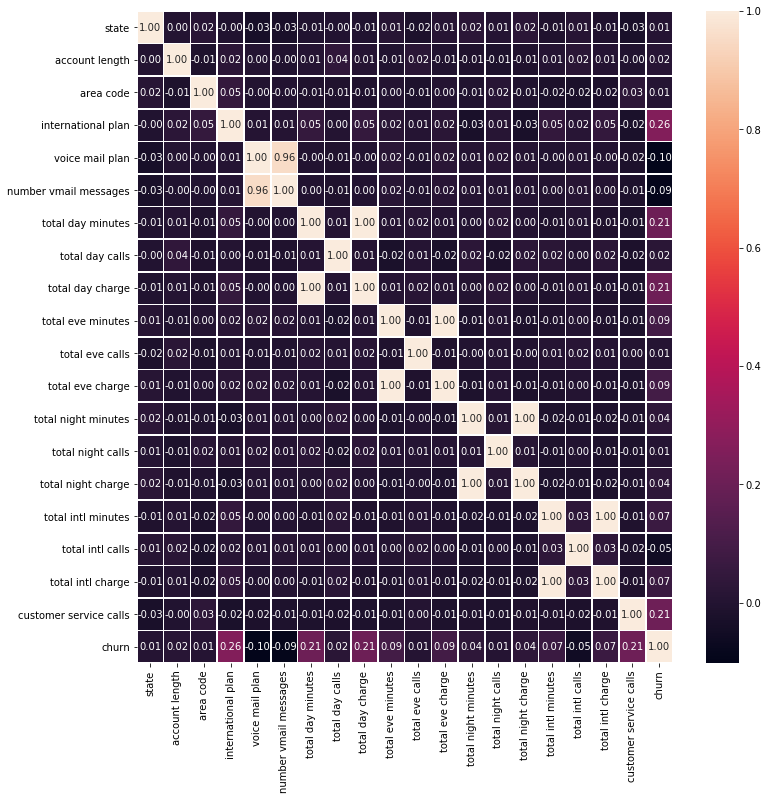

In [16]:
#Correlation heatmap
import seaborn as sns
f,ax= plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,linewidths=.6,fmt='.2f',ax=ax) 
plt.show() 

In [17]:
df['total minutes'] = df['total day minutes'] + df['total eve minutes'] + df['total night minutes'] + df['total intl minutes']
df['total calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls'] + df['total intl calls']
df['avgcall'] = df['total minutes']/df['total calls']
df['total charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge'] + df['total intl charge']

In [18]:
#confirm RFM
rfmTable = df.groupby('phone number').agg({'total minutes': lambda x: x.sum(), 
                                          'total charge': lambda x: x.sum()})
rfmTable.rename(columns={'total minutes': 'frequency', 
                         'total charge': 'monetary'}, inplace=True)

rfmTable.head()

,frequency,monetary
phone number,,
327-1058,494.8,47.42
327-1319,488.2,54.18
327-3053,483.1,43.33
327-3587,434.1,39.65
327-3850,662.6,60.12


In [19]:
# Create f_score

f_score = []
m_score = []
#r_score = []

columns = ['frequency', 'monetary']
scores_str = ['f_score', 'm_score']
scores = [f_score, m_score]

for n in range(len(columns)):
    # Order by column
    rfmTable = rfmTable.sort_values(columns[n], ascending=False)
    
    # Create new index
    refs = np.arange(1,3334)
    rfmTable['refs'] = refs
    
    # Add score
    for i, row in rfmTable.iterrows():
        if row['refs'] <= 666:
            scores[n].append(5)
        elif row['refs'] > 666 and row['refs'] <= 666*2:
            scores[n].append(4)
        elif row['refs'] > 666*2 and row['refs'] <= 666*3:
            scores[n].append(3)
        elif row['refs'] > 666*3 and row['refs'] <= 666*4:
            scores[n].append(2)
        else: 
            scores[n].append(1)

    # Create f_score column
    rfmTable[scores_str[n]] = scores[n]

rfmTableScores = rfmTable.drop(['frequency', 'monetary', 'refs'], axis=1)

rfmTableScores.head(1000)

,f_score,m_score
phone number,,
345-9140,5,5
351-7269,5,5
343-5709,5,5
373-2053,5,5
402-3370,5,5
345-3787,5,5
352-6976,5,5
348-1163,5,5
393-4823,5,5


In [20]:
#normalize our data so the prediction on all features will be at the same scale
X = rfmTableScores.iloc[:,[0,1]].values
from sklearn import preprocessing
    
X_train = preprocessing.MinMaxScaler().fit_transform(X)
#nurmalize the data
#from sklearn.preprocessing import StandardScaler
#X_std = StandardScaler().fit_transform(X)
#dfNorm = pd.DataFrame(X_std, index=rfmTableScores.index, columns=rfmTableScores.columns[0:2])

#X_train = dfNorm.iloc[:,0:2].values
X_train

F:\anaconda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [21]:
#Kmeans k = 1,2,...,11
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

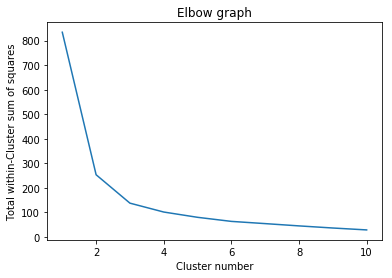

In [22]:
#elbow find k clusters optimal
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('Total within-Cluster sum of squares')
plt.show()


In [23]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(X_train)
kmeans_3 = kmeans.inertia_
centroids = kmeans.cluster_centers_
centroids

array([[0.10751979, 0.11103782],
       [0.50209497, 0.49860335],
       [0.89438503, 0.89416221]])

In [24]:
kmeans_1 = KMeans(n_clusters=1, init='k-means++', random_state=0)
clusters_1 = kmeans_1.fit_predict(X_train)
kmeans_1 = kmeans_1.inertia_

In [25]:
espsilon = kmeans_3/kmeans_1
Accuracy = 1 - espsilon
print("Accuracy Kmeans: %.2f" %Accuracy)

Accuracy Kmeans: 0.83


In [26]:
#show clusters of object
rfmTable['clusters'] = clusters
rfmTable.head(1000)


,frequency,monetary,refs,f_score,m_score,clusters
phone number,,,,,,
345-9140,885.0,96.15,1,5,5,2
351-7269,816.7,92.29,2,5,5,2
343-5709,831.3,92.20,3,5,5,2
373-2053,825.7,90.46,4,5,5,2
402-3370,821.8,90.12,5,5,5,2
345-3787,860.2,89.76,6,5,5,2
352-6976,882.2,89.31,7,5,5,2
348-1163,778.0,88.97,8,5,5,2
393-4823,815.8,88.66,9,5,5,2


Counter({0: 1137, 2: 1122, 1: 1074})


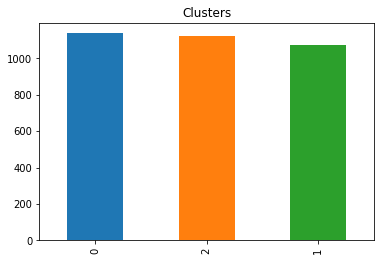

In [17]:
rfmTable["clusters"].value_counts().plot.bar(title= 'Clusters')
import collections
print(collections.Counter(clusters))

Text(0, 0.5, 'Monetary')

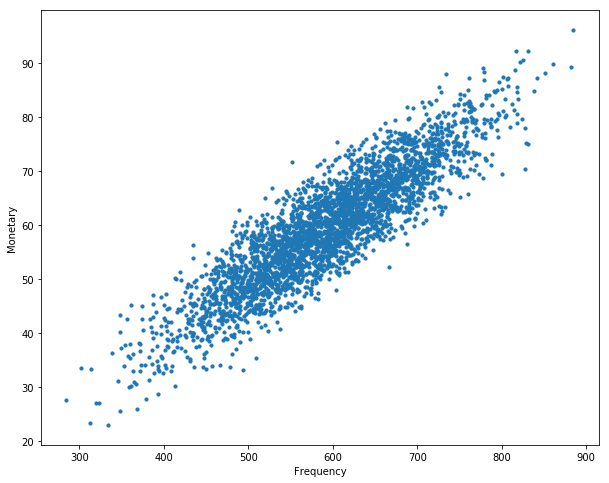

In [18]:
#plot FM in 2D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.scatter(rfmTable.frequency, rfmTable.monetary, s=10)

ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

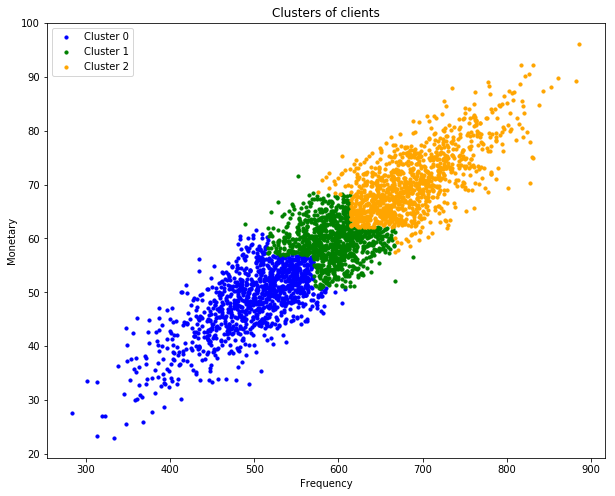

In [19]:
#plot clusters FM in 2D
fig = plt.figure(figsize=(10,8))
dx = fig.add_subplot(111)
colors = ['blue', 'green', 'orange']

for i in range(0,3):
    dx.scatter(rfmTable[rfmTable.clusters == i].frequency, 
               rfmTable[rfmTable.clusters == i].monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i), 
               s=10)
     
dx.set_title('Clusters of clients')
dx.set_xlabel('Frequency')
dx.set_ylabel('Monetary')
dx.legend()

In [20]:
#Data prepared for the hybrid method of Kmean and ANN
df = pd.merge(df, rfmTable, how='inner', on=['phone number'])
df.head(2)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total minutes,total calls,avgcall,total charge,frequency,monetary,refs,f_score,m_score,clusters
0,16,128,415,382-4657,0,1,25,265.1,110,45.07,...,717.2,303,2.366997,75.56,717.2,75.56,203,5,5,2
1,35,107,415,371-7191,0,1,26,161.6,123,27.47,...,625.2,332,1.883133,59.24,625.2,59.24,1690,4,3,1


In [21]:
# Encoding categorical data

labelencoder = LabelEncoder()
df.drop(["phone number"],axis = 1, inplace = True)
df.drop(["total minutes"],axis = 1, inplace = True)
df.drop(["total calls"],axis = 1, inplace = True)
df.drop(["total charge"],axis = 1, inplace = True)
df.drop(["frequency"],axis = 1, inplace = True)
df.drop(["monetary"],axis = 1, inplace = True)
df.drop(["refs"],axis = 1, inplace = True)
df.drop(["f_score"],axis = 1, inplace = True)
df.drop(["m_score"],axis = 1, inplace = True)
#df.drop(["avgcall"],axis = 1, inplace = True)

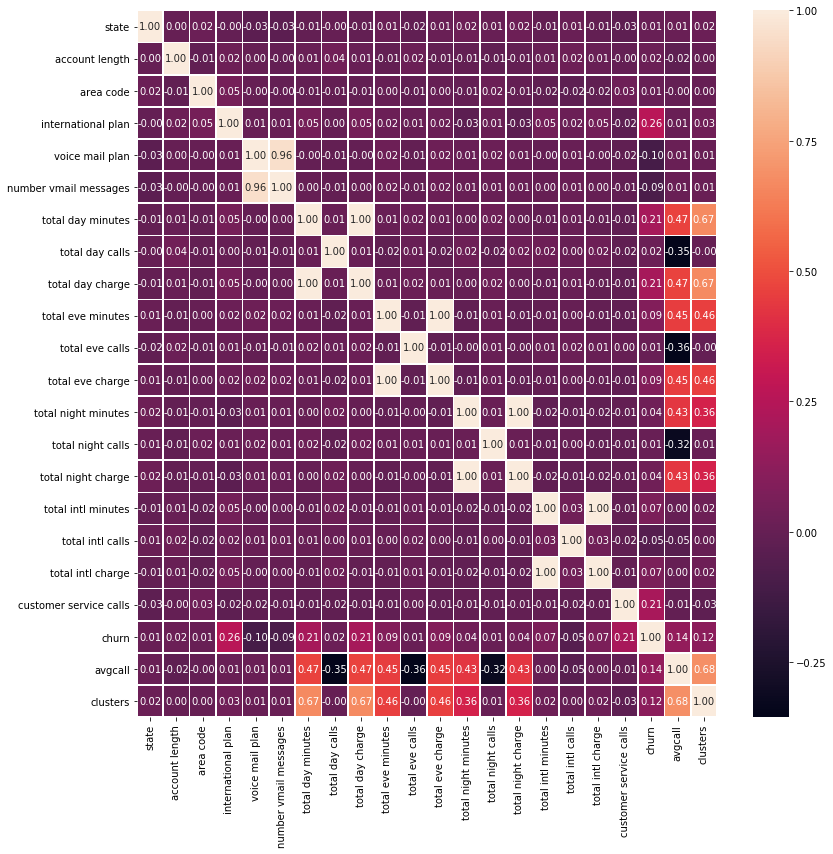

In [22]:
#Correlation heatmap
import seaborn as sns
f,ax= plt.subplots(figsize=(13,13))
sns.heatmap(df.corr(),annot=True,linewidths=.6,fmt='.2f',ax=ax) 
plt.show() 

In [23]:
#Select attributes for training
#X = df.iloc[:,[3,4,5,6,8,9,11,12,14,15,16,17,18,20]].values
X = df.iloc[:,[3,4,5,6,8,9,11,14,15,16,17,18,20,21]].values
y = df.iloc[:,19].values
X[0]

array([  0.       ,   1.       ,  25.       , 265.1      ,  45.07     ,
       197.4      ,  16.78     ,  11.01     ,  10.       ,   3.       ,
         2.7      ,   1.       ,   2.3669967,   2.       ])

In [24]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [25]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [26]:
#balance ratio y = 0 và y = 1
sm = SMOTE(random_state=0, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [27]:
#data labels before SMOTE:
import collections
collections.Counter(y_train)

Counter({0: 2271, 1: 395})

In [28]:
#after SMOTE:
import collections
collections.Counter(y_train_res)

Counter({0: 2271, 1: 2271})

In [29]:
# Part 2 -  build model the ANN
# biuld model the ANN
n_input = X_train_res.shape[1]
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 9, init = 'uniform', activation = 'relu', input_dim = (n_input)))
classifier.add(Dropout(p = 0.2))
# Adding the second hidden layer
classifier.add(Dense(output_dim = 5, init = 'uniform', activation = 'relu'))
classifier.add(Dropout(p = 0.2))
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
history = classifier.fit(X_train_res, y_train_res, batch_size = 20, validation_split=0.2, nb_epoch = 170, verbose = 1)

# list all data in history
print(history.history.keys())


F:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=14, units=9, kernel_initializer="uniform")`
  import sys
F:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.2)`
  
F:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=5, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
F:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.2)`
  # This is added back by InteractiveShellApp.init_path()
F:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units

Train on 3633 samples, validate on 909 samples
Epoch 1/170
3633/3633 [==============================] - 2s 679us/step - loss: 0.6738 - acc: 0.6738 - val_loss: 0.5600 - val_acc: 0.6546
Epoch 2/170
3633/3633 [==============================] - 1s 256us/step - loss: 0.6117 - acc: 0.7605 - val_loss: 0.5205 - val_acc: 0.6645
Epoch 3/170
3633/3633 [==============================] - 1s 239us/step - loss: 0.5695 - acc: 0.8035 - val_loss: 0.4787 - val_acc: 0.7250
Epoch 4/170
3633/3633 [==============================] - 1s 242us/step - loss: 0.5270 - acc: 0.8337 - val_loss: 0.4335 - val_acc: 0.7910
Epoch 5/170
3633/3633 [==============================] - 1s 243us/step - loss: 0.4955 - acc: 0.8503 - val_loss: 0.4173 - val_acc: 0.8251
Epoch 6/170
3633/3633 [==============================] - 1s 213us/step - loss: 0.4623 - acc: 0.8494 - val_loss: 0.4597 - val_acc: 0.7965
Epoch 7/170
3633/3633 [==============================] - 1s 238us/step - loss: 0.4454 - acc: 0.8536 - val_loss: 0.3909 - val_acc: 0

3633/3633 [==============================] - 1s 155us/step - loss: 0.2912 - acc: 0.8962 - val_loss: 0.3673 - val_acc: 0.8449
Epoch 61/170
3633/3633 [==============================] - 1s 152us/step - loss: 0.2954 - acc: 0.8938 - val_loss: 0.3708 - val_acc: 0.8493
Epoch 62/170
3633/3633 [==============================] - 1s 156us/step - loss: 0.2864 - acc: 0.8973 - val_loss: 0.3603 - val_acc: 0.8526
Epoch 63/170
3633/3633 [==============================] - 1s 165us/step - loss: 0.2873 - acc: 0.8968 - val_loss: 0.3498 - val_acc: 0.8647
Epoch 64/170
3633/3633 [==============================] - 1s 169us/step - loss: 0.2985 - acc: 0.8957 - val_loss: 0.3391 - val_acc: 0.8603
Epoch 65/170
3633/3633 [==============================] - 1s 155us/step - loss: 0.2829 - acc: 0.9020 - val_loss: 0.3377 - val_acc: 0.8570
Epoch 66/170
3633/3633 [==============================] - 1s 184us/step - loss: 0.2817 - acc: 0.9039 - val_loss: 0.3311 - val_acc: 0.8614
Epoch 67/170
3633/3633 [=======================

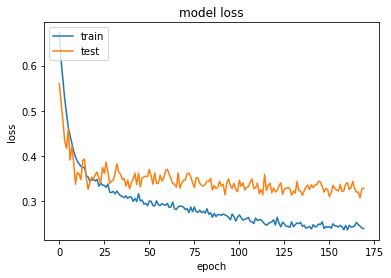

4542/4542 [==============================] - 0s 41us/step

acc: 92.32%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 135       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# evaluate the model on training set
scores = classifier.evaluate(X_train_res, y_train_res)
print("\n%s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))
#structure model
classifier.summary()
#save model
filename = 'finalized_model.pkl'
pickle.dump(classifier, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [31]:
# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results

#evaluate the model on test set
loss_and_metrics = loaded_model.evaluate(X_test, y_test, batch_size = 20)
print("\nTest score: %.2f%%" % (loss_and_metrics[1]*100))
y_pred = loaded_model.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix")
print(cm)
print(classification_report(y_test, y_pred))

667/667 [==============================] - 0s 274us/step

Test score: 97.00%
Confusion matrix
[[574   5]
 [ 15  73]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       579
           1       0.94      0.83      0.88        88

   micro avg       0.97      0.97      0.97       667
   macro avg       0.96      0.91      0.93       667
weighted avg       0.97      0.97      0.97       667



In [32]:
#Part 4 - Evaluatic consequent model

#evaluation model
from sklearn import metrics
accuracy_score = metrics.accuracy_score(y_test,y_pred)
print("Accuracy: %f" %accuracy_score)
precision_score = metrics.precision_score(y_test, y_pred)
print("Precision: %f" %precision_score)
recall_score = metrics.recall_score(y_test, y_pred)
print("Recall: %f" %recall_score)
F1_score = metrics.f1_score(y_test, y_pred)
print("F1_score: %f" %F1_score)
Fbeta_score = metrics.fbeta_score(y_test, y_pred, beta=0.5) 
print("Fbta_score: %f" %Fbeta_score)

Accuracy: 0.970015
Precision: 0.935897
Recall: 0.829545
F1_score: 0.879518
Fbta_score: 0.912500


In [33]:
#roc_curve indicates the corresponding True Positive Rate and False Positive Rate on the coordinate axis
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
print('Thresholds:')
print(thresholds)

Thresholds:
[2 1 0]


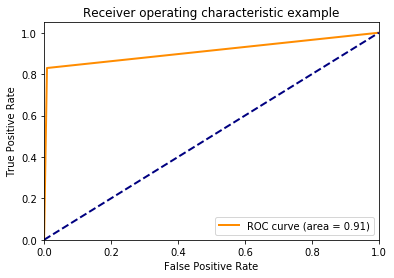

In [34]:
import matplotlib.pyplot as plt
from itertools import cycle
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [35]:
#Precision-Recall curve indicates the corresponding Precision and Recall on the coordinate axis
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.80


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.80')

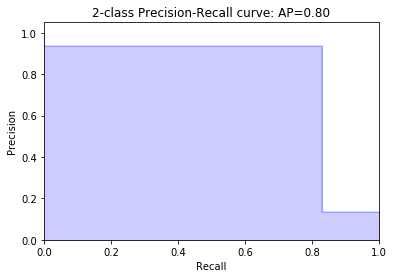

In [36]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))